# Análise de Vendas no GCP com BigQuery - Lucas

Este notebook realiza diversas consultas SQL em uma base de dados grande hospedada no Google Cloud Platform (GCP) utilizando o BigQuery. As consultas abrangem análises de vendas por região, departamento, categoria, loja e outros parâmetros relevantes.

## 1. Configuração e Importações

In [1]:
import os

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy.types import Integer, String, Float, DateTime
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import plotly.express as px

# Configurações para visualizações
%matplotlib inline
sns.set(style="whitegrid")

## 2. Autenticação e Conexão com o BigQuery

In [2]:
# Caminho para o arquivo de chave da conta de serviço
service_account_path = 'tfm-sa.json'

# Criar objeto de credenciais
credentials = service_account.Credentials.from_service_account_file(service_account_path)

# Configurações do projeto e dataset
project_id = 'perseverance-332400'
dataset_id = 'TFM'
table_id = 'ds_market'
full_table_id = f'{project_id}.{dataset_id}.{table_id}'

# Criar cliente BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

## 3. Listagem e Visualização das Colunas e Dados

### 3.1. Listando as Colunas Disponíveis na Tabela

In [3]:
# Obter o esquema da tabela
table = client.get_table(full_table_id)  # Faz uma chamada API para obter a tabela

# Extrair os nomes das colunas
columns = [schema_field.name for schema_field in table.schema]

# Exibir as colunas
print("Colunas disponíveis na tabela `TFM.ds_market`:")
for column in columns:
    print(f"- {column}")

Colunas disponíveis na tabela `TFM.ds_market`:
- id
- item
- category_x
- department
- store
- store_code
- region
- d
- sales
- yearweek
- date
- event
- category_y
- sell_price


### 3.2. Obtendo um Conjunto de Dados de Amostra

In [4]:
# Definir uma consulta para obter as primeiras 10 linhas da tabela
sample_query = f"""
SELECT *
FROM `{full_table_id}`
LIMIT 10;
"""

# Definir a função para executar consultas
def executar_consulta(sql, client):
    """
    Executa uma consulta SQL no BigQuery e retorna um DataFrame do Pandas.
    
    Args:
        sql (str): A consulta SQL a ser executada.
        client (bigquery.Client): Cliente do BigQuery.

    Returns:
        pd.DataFrame: Resultado da consulta.
    """
    query_job = client.query(sql)
    return query_job.to_dataframe()

# Executar a consulta
df_sample = executar_consulta(sample_query, client)

# Exibir o DataFrame de amostra
df_sample

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,id,item,category_x,department,store,store_code,region,d,sales,yearweek,date,event,category_y,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1217,0,201422,2014-05-29 00:00:00+00:00,None,ACCESORIES,10.9858
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1899,0,201614,2016-04-10 00:00:00+00:00,None,ACCESORIES,10.9858
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_865,0,201324,2013-06-11 00:00:00+00:00,None,None,NaN
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_96,0,201118,2011-05-04 00:00:00+00:00,None,None,NaN
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_373,0,201205,2012-02-05 00:00:00+00:00,SuperBowl,None,NaN
5,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1789,1,201552,2015-12-22 00:00:00+00:00,None,ACCESORIES,10.9858
6,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1163,0,201414,2014-04-05 00:00:00+00:00,None,ACCESORIES,10.9858
7,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1377,0,201445,2014-11-05 00:00:00+00:00,None,ACCESORIES,10.9858
8,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1366,0,201443,2014-10-25 00:00:00+00:00,None,ACCESORIES,10.9858
9,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,d_1457,0,201504,2015-01-24 00:00:00+00:00,None,ACCESORIES,5.2801


### 3.3. Inspecionando os Tipos de Dados das Colunas

In [5]:
print("Esquema da tabela `TFM.ds_market`:")
for schema_field in table.schema:
    print(f"- {schema_field.name}: {schema_field.field_type}")

Esquema da tabela `TFM.ds_market`:
- id: STRING
- item: STRING
- category_x: STRING
- department: STRING
- store: STRING
- store_code: STRING
- region: STRING
- d: STRING
- sales: INTEGER
- yearweek: STRING
- date: TIMESTAMP
- event: STRING
- category_y: STRING
- sell_price: FLOAT


## 4. Definição das Consultas SQL Refinadas

In [6]:
# Consulta 1: Total de vendas por loja, região e departamento com contribuição percentual
query_total_vendas_loja = """
SELECT
  region,
  department,
  store,
  SUM(sales) AS total_sales,
  (SUM(sales) / SUM(SUM(sales)) OVER (PARTITION BY region, department)) * 100 AS sales_contribution_percentage
FROM
  `TFM.ds_market`
GROUP BY
  region,
  department,
  store;
"""

# Consulta 2 Refinada: Total de vendas por category_x, região e semana com contribuição percentual
query_vendas_category = """
SELECT
  region,
  yearweek,
  category_x,
  SUM(sales) AS total_sales,
  (SUM(sales) / SUM(SUM(sales)) OVER (PARTITION BY region, yearweek)) * 100 AS sales_contribution_percentage
FROM
  `TFM.ds_market`
GROUP BY
  region,
  yearweek,
  category_x;
"""

# Consulta 3: Os 5 itens com as maiores vendas para uma determinada região e semana do ano, com contribuição percentual
query_top_5_itens = """
SELECT
  region,
  yearweek,
  item,
  SUM(sales) AS total_sales,
  (SUM(sales) / SUM(SUM(sales)) OVER (PARTITION BY region, yearweek)) * 100 AS sales_contribution_percentage
FROM
  `TFM.ds_market`
WHERE
  region = 'US'
  AND yearweek = '201552'
GROUP BY
  region,
  yearweek,
  item
ORDER BY
  total_sales DESC
LIMIT
  5;
"""

# Consulta 4: Total de vendas por loja, região e semana do ano com variação percentual ano a ano
query_total_vendas_loja_variacao = """
SELECT
  region,
  yearweek,
  store,
  SUM(sales) AS total_sales,
  (SUM(sales) / SUM(SUM(sales)) OVER (PARTITION BY region)) * 100 AS sales_contribution_percentage
FROM
  `TFM.ds_market`
GROUP BY
  region,
  yearweek,
  store;
"""

# Consulta 5: As 5 lojas com as maiores vendas médias para uma determinada região e semana do ano
query_top_5_lojas_media = """
SELECT
  region,
  yearweek,
  store,
  AVG(sales) AS avg_sales
FROM
  `TFM.ds_market`
WHERE
  region = 'US'
  AND yearweek = '201552'
GROUP BY
  region,
  yearweek,
  store
ORDER BY
  avg_sales DESC
LIMIT
  5;
"""

# Consulta 6: Correlação entre vendas e preço de venda para cada região
query_correlacao_vendas_preco = """
SELECT
  region,
  CORR(sales, sell_price) AS sales_sell_price_corr
FROM
  `TFM.ds_market`
GROUP BY
  region;
"""

# Consulta 7: Os 5 itens com as maiores vendas para uma determinada região e semana do ano
query_top_5_itens_vendas = """
SELECT
  item,
  SUM(sales) AS total_sales
FROM
  `TFM.ds_market`
WHERE
  region = 'US'
  AND yearweek = '201552'
GROUP BY
  item
ORDER BY
  total_sales DESC
LIMIT
  5;
"""

# Consulta 8: Total de vendas por loja, região e departamento
query_total_vendas_loja_departamento = """
SELECT
  region,
  department,
  SUM(sales) AS total_sales
FROM
  `TFM.ds_market`
GROUP BY
  region,
  department;
"""

# Consulta 9 Refinada: Preço de venda máximo para cada região e loja
query_preco_max_category = """
SELECT
  region,
  store,
  MAX(sell_price) AS max_sell_price
FROM
  `TFM.ds_market`
GROUP BY
  region,
  store;
"""

# Consulta 10: Desvio padrão das vendas para cada loja, agrupadas por região e ano-semana
query_stddev_vendas = """
SELECT
  region,
  yearweek,
  store,
  STDDEV(sales) AS stddev_sales
FROM
  `TFM.ds_market`
GROUP BY
  region,
  yearweek,
  store;
"""

# Consulta 11: Média de vendas por região para cada ano-semana
query_media_vendas_regiao = """
SELECT
  region,
  yearweek,
  AVG(sales) AS average_sales
FROM
  `TFM.ds_market`
WHERE
  date BETWEEN '2011-01-01' AND '2016-12-31'
GROUP BY
  region,
  yearweek;
"""

# Consulta 12: Desvio padrão das vendas por departamento para o ano de 2022
query_stddev_departamento = """
SELECT
  department,
  STDDEV_SAMP(sales) AS sales_standard_deviation
FROM
  `TFM.ds_market`
WHERE
  date BETWEEN '2011-01-01' AND '2016-12-31'
GROUP BY
  department;
"""

# Consulta 13: 5 itens com o maior preço médio de venda
query_top_5_preco_medio = """
SELECT
  item,
  AVG(sell_price) AS average_sell_price
FROM
  `TFM.ds_market`
WHERE
  date BETWEEN '2011-01-01' AND '2016-12-31'
GROUP BY
  item
ORDER BY
  average_sell_price DESC
LIMIT
  5;
"""

# Consulta 14: Correlação entre vendas e preço de venda para o ano de 2022
query_correlacao_2022 = """
SELECT
  CORR(sales, sell_price) AS sales_sell_price_correlation
FROM
  `TFM.ds_market`
WHERE
  date BETWEEN '2011-01-01' AND '2016-12-31';
"""

# Consulta 15: Média de vendas por loja para cada combinação de região e ano-semana
query_media_vendas_loja = """
SELECT
  region,
  yearweek,
  store,
  AVG(sales) AS average_sales
FROM
  `TFM.ds_market`
WHERE
  date BETWEEN '2011-01-01' AND '2016-12-31'
GROUP BY
  region,
  yearweek,
  store;
"""

# Consulta 16: Preço médio de venda para cada combinação de category_x e código da loja
query_preco_medio_categoria_loja = """
SELECT
  category_x,
  store_code,
  AVG(sell_price) AS avg_sell_price
FROM
  `TFM.ds_market`
GROUP BY
  category_x,
  store_code;
"""

# Executando a Consulta 17
query_variacao_percentual_vendas = """
SELECT
    region,
    yearweek,
    sales,
    (sales - LAG(sales, 1, 0) OVER (PARTITION BY region ORDER BY yearweek)) * 100.0 / NULLIF(LAG(sales, 1, 0) OVER (PARTITION BY region ORDER BY yearweek), 0) AS sales_change_percent
FROM
    `TFM.ds_market`
WHERE
    yearweek > '201501';
"""

# Consulta 18 Refinada: Vendas acumuladas para cada loja ao longo do tempo
query_vendas_acumuladas = """
SELECT
  store_code,
  date,
  SUM(sales) OVER (PARTITION BY store_code ORDER BY date) AS cumulative_sales
FROM
  `TFM.ds_market`
ORDER BY
  store_code,
  date;
"""

# Consulta 19: Média móvel de 7 dias das vendas para cada região
query_media_movel_7dias = """
SELECT
  region,
  date,
  AVG(sales) OVER (PARTITION BY region ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg_sales
FROM
  `TFM.ds_market`
ORDER BY
  region,
  date;
"""

# Consulta 20: Total de vendas por evento e departamento com classificação dentro de cada evento
query_vendas_evento_departamento = """
SELECT
  event,
  department,
  SUM(sales) AS total_sales,
  RANK() OVER (PARTITION BY event ORDER BY SUM(sales) DESC) AS sales_rank
FROM
  `TFM.ds_market`
GROUP BY
  event,
  department
ORDER BY
  event,
  sales_rank;
"""

# Consulta 21: As 3 regiões com o maior total de vendas para uma categoria específica
query_top_3_regioes_categoria = """
SELECT
  region,
  SUM(sales) AS total_sales
FROM
  `TFM.ds_market`
WHERE
  category_x = 'ACCESORIES'
GROUP BY
  region
ORDER BY
  total_sales DESC
LIMIT
  3;
"""

# Consulta 22: As 5 lojas com o maior preço médio de venda para um departamento específico
query_top_5_lojas_preco_medio = """
SELECT
  store_code,
  AVG(sell_price) AS avg_sell_price
FROM
  `TFM.ds_market`
WHERE
  department = 'ACCESORIES_1'
GROUP BY
  store_code
ORDER BY
  avg_sell_price DESC
LIMIT
  5;
"""

# Consulta 23: Os 3 eventos com o maior total de vendas para um item específico
query_top_3_eventos_item = """
SELECT
  event,
  SUM(sales) AS total_sales
FROM
  `TFM.ds_market`
WHERE
  item = 'ACCESORIES_1_001'
GROUP BY
  event
ORDER BY
  total_sales DESC
LIMIT
  3;
"""

# Consulta 24: As 5 categorias com a maior média de vendas para uma loja específica
query_top_5_categorias_media_loja = """
SELECT
  category_x,
  AVG(sales) AS avg_sales
FROM
  `TFM.ds_market`
WHERE
  store_code = 'BOS_1'
GROUP BY
  category_x
ORDER BY
  avg_sales DESC
LIMIT
  5;
"""

## 5. Execução das Consultas Refinadas e Armazenamento dos Resultados

In [7]:
# Executando a Consulta 1
df_total_vendas_loja = executar_consulta(query_total_vendas_loja, client)
print("Consulta 1: Total de Vendas por Loja, Região e Departamento")
df_total_vendas_loja.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 1: Total de Vendas por Loja, Região e Departamento


,region,department,store,total_sales,sales_contribution_percentage
0,Boston,HOME_&_GARDEN_1,Back_Bay,1160930,32.593199
1,Boston,HOME_&_GARDEN_1,South_End,1146240,32.180777
2,Boston,HOME_&_GARDEN_1,Roxbury,1254708,35.226024
3,Boston,ACCESORIES_2,South_End,43079,23.185184
4,Boston,ACCESORIES_2,Back_Bay,67345,36.245183


In [8]:
# Executando a Consulta 2 Refinada
df_vendas_category = executar_consulta(query_vendas_category, client)
print("Consulta 2: Total de Vendas por Category_X, Região e Semana")
df_vendas_category.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 2: Total de Vendas por Category_X, Região e Semana


,region,yearweek,category_x,total_sales,sales_contribution_percentage
0,Boston,201111,HOME_&_GARDEN,10059,18.825797
1,Boston,201111,ACCESORIES,4327,8.098143
2,Boston,201111,SUPERMARKET,39046,73.076059
3,Boston,201215,SUPERMARKET,53736,74.678970
4,Boston,201215,HOME_&_GARDEN,12815,17.809495


In [9]:
# Executando a Consulta 3
df_top_5_itens = executar_consulta(query_top_5_itens, client)
print("Consulta 3: Top 5 Itens com Maiores Vendas")
df_top_5_itens.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 3: Top 5 Itens com Maiores Vendas


,region,yearweek,item,total_sales,sales_contribution_percentage


In [10]:
# Executando a Consulta 4
df_total_vendas_loja_variacao = executar_consulta(query_total_vendas_loja_variacao, client)
print("Consulta 4: Total de Vendas por Loja com Variação Percentual")
df_total_vendas_loja_variacao.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 4: Total de Vendas por Loja com Variação Percentual


,region,yearweek,store,total_sales,sales_contribution_percentage
0,Boston,201427,South_End,23581,0.124717
1,Boston,201310,South_End,20673,0.109337
2,Boston,201415,South_End,24023,0.127054
3,Boston,201109,South_End,15290,0.080867
4,Boston,201441,South_End,21171,0.111971


In [11]:
# Executando a Consulta 5
df_top_5_lojas_media = executar_consulta(query_top_5_lojas_media, client)
print("Consulta 5: Top 5 Lojas com Maiores Vendas Médias")
df_top_5_lojas_media.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 5: Top 5 Lojas com Maiores Vendas Médias


,region,yearweek,store,avg_sales


In [12]:
# Executando a Consulta 6
df_correlacao_vendas_preco = executar_consulta(query_correlacao_vendas_preco, client)
print("Consulta 6: Correlação entre Vendas e Preço de Venda por Região")
df_correlacao_vendas_preco.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 6: Correlação entre Vendas e Preço de Venda por Região


,region,sales_sell_price_corr
0,New York,-0.148682
1,Philadelphia,-0.167442
2,Boston,-0.140856


In [13]:
# Executando a Consulta 7
df_top_5_itens_vendas = executar_consulta(query_top_5_itens_vendas, client)
print("Consulta 7: Top 5 Itens com Maiores Vendas para US na Semana 201552")
df_top_5_itens_vendas.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 7: Top 5 Itens com Maiores Vendas para US na Semana 201552


,item,total_sales


In [14]:
# Executando a Consulta 8
df_total_vendas_loja_departamento = executar_consulta(query_total_vendas_loja_departamento, client)
print("Consulta 8: Total de Vendas por Loja, Região e Departamento")
df_total_vendas_loja_departamento.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 8: Total de Vendas por Loja, Região e Departamento


,region,department,total_sales
0,New York,SUPERMARKET_1,2366684
1,New York,HOME_&_GARDEN_1,4887357
2,Boston,SUPERMARKET_3,9508346
3,New York,SUPERMARKET_2,2958209
4,New York,HOME_&_GARDEN_2,1554811


In [15]:
# Executando a Consulta 9 Refinada
df_preco_max_category = executar_consulta(query_preco_max_category, client)
print("Consulta 9: Preço de Venda Máximo por Região e Loja")
df_preco_max_category.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 9: Preço de Venda Máximo por Região e Loja


,region,store,max_sell_price
0,Boston,Back_Bay,41.2034
1,New York,Brooklyn,41.2034
2,Philadelphia,Midtown_Village,44.8500
3,Boston,South_End,65.7750
4,New York,Tribeca,41.2034


In [16]:
# Executando a Consulta 10
df_stddev_vendas = executar_consulta(query_stddev_vendas, client)
print("Consulta 10: Desvio Padrão das Vendas por Loja, Região e Ano-Semana")
df_stddev_vendas.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 10: Desvio Padrão das Vendas por Loja, Região e Ano-Semana


,region,yearweek,store,stddev_sales
0,Boston,201152,South_End,3.594471
1,Boston,201535,South_End,2.886657
2,Boston,201451,South_End,3.068281
3,Boston,201304,South_End,3.123990
4,Boston,201403,South_End,3.231388


In [17]:
# Executando a Consulta 11
df_media_vendas_regiao = executar_consulta(query_media_vendas_regiao, client)
print("Consulta 11: Média de Vendas por Região para Cada Ano-Semana")
df_media_vendas_regiao.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 11: Média de Vendas por Região para Cada Ano-Semana


,region,yearweek,average_sales
0,Boston,201609,1.231572
1,Boston,201123,0.934981
2,Boston,201528,1.254938
3,Boston,201203,0.933046
4,Boston,201436,1.168410


In [18]:
# Executando a Consulta 12
df_stddev_departamento = executar_consulta(query_stddev_departamento, client)
print("Consulta 12: Desvio Padrão das Vendas por Departamento para 2022")
df_stddev_departamento.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 12: Desvio Padrão das Vendas por Departamento para 2022


,department,sales_standard_deviation
0,SUPERMARKET_3,6.319670
1,ACCESORIES_2,0.752022
2,HOME_&_GARDEN_2,0.830119
3,SUPERMARKET_2,2.691415
4,ACCESORIES_1,2.314792


In [19]:
# Executando a Consulta 13
df_top_5_preco_medio = executar_consulta(query_top_5_preco_medio, client)
print("Consulta 13: Top 5 Itens com Maior Preço Médio de Venda")
df_top_5_preco_medio.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 13: Top 5 Itens com Maior Preço Médio de Venda


,item,average_sell_price
0,ACCESORIES_1_225,39.492646
1,ACCESORIES_1_060,39.486032
2,ACCESORIES_1_361,39.485912
3,ACCESORIES_1_410,37.969485
4,ACCESORIES_1_393,37.907451


In [20]:
# Executando a Consulta 14
df_correlacao_2022 = executar_consulta(query_correlacao_2022, client)
print("Consulta 14: Correlação entre Vendas e Preço de Venda para 2022")
df_correlacao_2022.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 14: Correlação entre Vendas e Preço de Venda para 2022


,sales_sell_price_correlation
0,-0.15108


In [21]:
# Executando a Consulta 15
df_media_vendas_loja = executar_consulta(query_media_vendas_loja, client)
print("Consulta 15: Média de Vendas por Loja para Cada Região e Ano-Semana")
df_media_vendas_loja.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 15: Média de Vendas por Loja para Cada Região e Ano-Semana


,region,yearweek,store,average_sales
0,Boston,201304,South_End,0.854193
1,Boston,201228,South_End,1.023146
2,Boston,201451,South_End,0.998642
3,Boston,201152,South_End,0.800328
4,Boston,201142,South_End,0.776347


In [22]:
# Executando a Consulta 16
df_preco_medio_categoria_loja = executar_consulta(query_preco_medio_categoria_loja, client)
print("Consulta 16: Preço Médio de Venda por Category_X e Código da Loja")
df_preco_medio_categoria_loja.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 16: Preço Médio de Venda por Category_X e Código da Loja


,category_x,store_code,avg_sell_price
0,SUPERMARKET,BOS_3,3.874553
1,HOME_&_GARDEN,BOS_3,6.823749
2,SUPERMARKET,PHI_2,3.930609
3,ACCESORIES,PHI_3,7.083361
4,ACCESORIES,BOS_1,7.017132


In [23]:
df_variacao_percentual_vendas = executar_consulta(query_variacao_percentual_vendas, client)
print("Consulta 17: Variação Percentual das Vendas por Ano-Semana e Category_X")
df_variacao_percentual_vendas.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 17: Variação Percentual das Vendas por Ano-Semana e Category_X


,region,yearweek,sales,sales_change_percent
0,New York,201533,13,1200.00000
1,New York,201533,2,-90.47619
2,New York,201533,3,-25.00000
3,New York,201533,1,-80.00000
4,New York,201533,1,-80.00000


In [24]:
# Executando a Consulta 18 Refinada
df_vendas_acumuladas = executar_consulta(query_vendas_acumuladas, client)
print("Consulta 18: Vendas Acumuladas por Código da Loja ao Longo do Tempo")
df_vendas_acumuladas.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 18: Vendas Acumuladas por Código da Loja ao Longo do Tempo


,store_code,date,cumulative_sales
0,BOS_1,2011-01-29 00:00:00+00:00,2556
1,BOS_1,2011-01-29 00:00:00+00:00,2556
2,BOS_1,2011-01-29 00:00:00+00:00,2556
3,BOS_1,2011-01-29 00:00:00+00:00,2556
4,BOS_1,2011-01-29 00:00:00+00:00,2556


In [25]:
# Executando a Consulta 19
df_media_movel_7dias = executar_consulta(query_media_movel_7dias, client)
print("Consulta 19: Média Móvel de 7 Dias das Vendas por Região")
df_media_movel_7dias.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 19: Média Móvel de 7 Dias das Vendas por Região


,region,date,moving_avg_sales
0,Boston,2011-01-29 00:00:00+00:00,0.428571
1,Boston,2011-01-29 00:00:00+00:00,0.428571
2,Boston,2011-01-29 00:00:00+00:00,0.428571
3,Boston,2011-01-29 00:00:00+00:00,0.000000
4,Boston,2011-01-29 00:00:00+00:00,0.428571


In [26]:
# Executando a Consulta 20
df_vendas_evento_departamento = executar_consulta(query_vendas_evento_departamento, client)
print("Consulta 20: Total de Vendas por Evento e Departamento com Classificação")
df_vendas_evento_departamento.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 20: Total de Vendas por Evento e Departamento com Classificação


,event,department,total_sales,sales_rank
0,None,SUPERMARKET_3,31939824,1
1,None,HOME_&_GARDEN_1,11364593,2
2,None,SUPERMARKET_2,7542692,3
3,None,ACCESORIES_1,5534560,4
4,None,SUPERMARKET_1,5027025,5


In [27]:
# Executando a Consulta 21
df_top_3_regioes_categoria = executar_consulta(query_top_3_regioes_categoria, client)
print("Consulta 21: Top 3 Regiões com Maior Total de Vendas para 'ACCESORIES'")
df_top_3_regioes_categoria.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 21: Top 3 Regiões com Maior Total de Vendas para 'ACCESORIES'


,region,total_sales
0,New York,3040885
1,Boston,1592654
2,Philadelphia,1493440


In [28]:
# Executando a Consulta 22
df_top_5_lojas_preco_medio = executar_consulta(query_top_5_lojas_preco_medio, client)
print("Consulta 22: Top 5 Lojas com Maior Preço Médio de Venda para 'ACCESORIES_1'")
df_top_5_lojas_preco_medio.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 22: Top 5 Lojas com Maior Preço Médio de Venda para 'ACCESORIES_1'


,store_code,avg_sell_price
0,PHI_2,8.332554
1,NYC_2,8.328753
2,PHI_1,8.311760
3,NYC_4,8.304636
4,NYC_3,8.293459


In [29]:
# Executando a Consulta 23
df_top_3_eventos_item = executar_consulta(query_top_3_eventos_item, client)
print("Consulta 23: Top 3 Eventos com Maior Total de Vendas para 'ACCESORIES_1_001'")
df_top_3_eventos_item.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 23: Top 3 Eventos com Maior Total de Vendas para 'ACCESORIES_1_001'


,event,total_sales
0,None,4038
1,Easter,13
2,SuperBowl,12


In [30]:
# Executando a Consulta 24
df_top_5_categorias_media_loja = executar_consulta(query_top_5_categorias_media_loja, client)
print("Consulta 24: Top 5 Categorias com Maior Média de Vendas para 'BOS_1'")
df_top_5_categorias_media_loja.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Consulta 24: Top 5 Categorias com Maior Média de Vendas para 'BOS_1'


,category_x,avg_sales
0,SUPERMARKET,1.374247
1,HOME_&_GARDEN,0.693021
2,ACCESORIES,0.396965


## 6. Análise e Visualização dos Dados

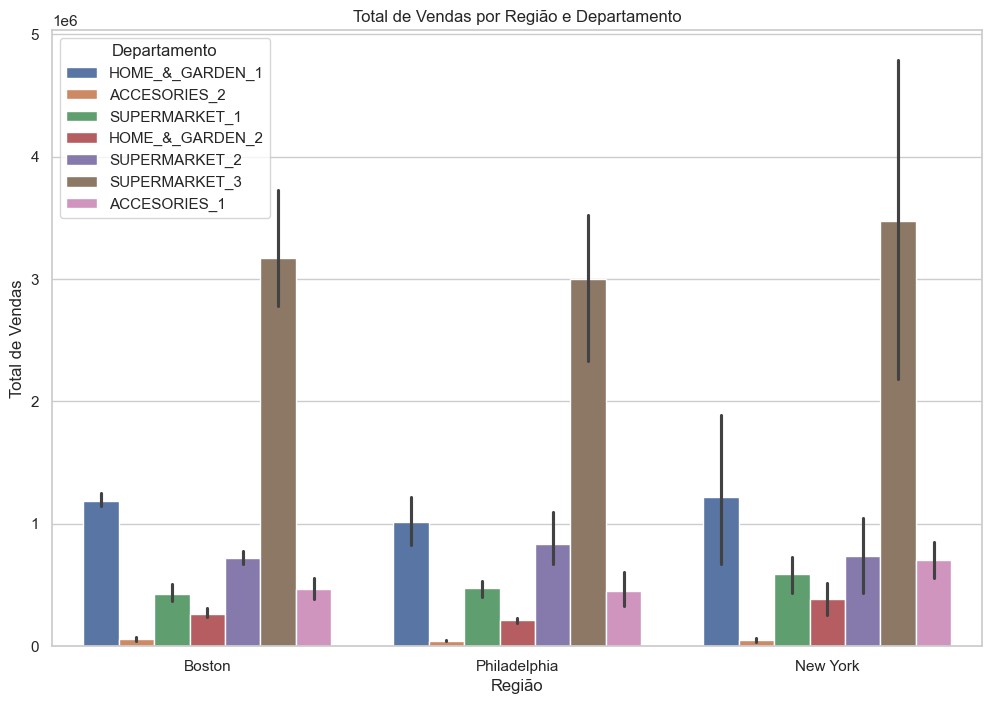

In [31]:
# Exemplo de visualização: Total de Vendas por Região e Departamento
plt.figure(figsize=(12, 8))
sns.barplot(data=df_total_vendas_loja, x='region', y='total_sales', hue='department')
plt.title('Total de Vendas por Região e Departamento')
plt.xlabel('Região')
plt.ylabel('Total de Vendas')
plt.legend(title='Departamento')
plt.show()

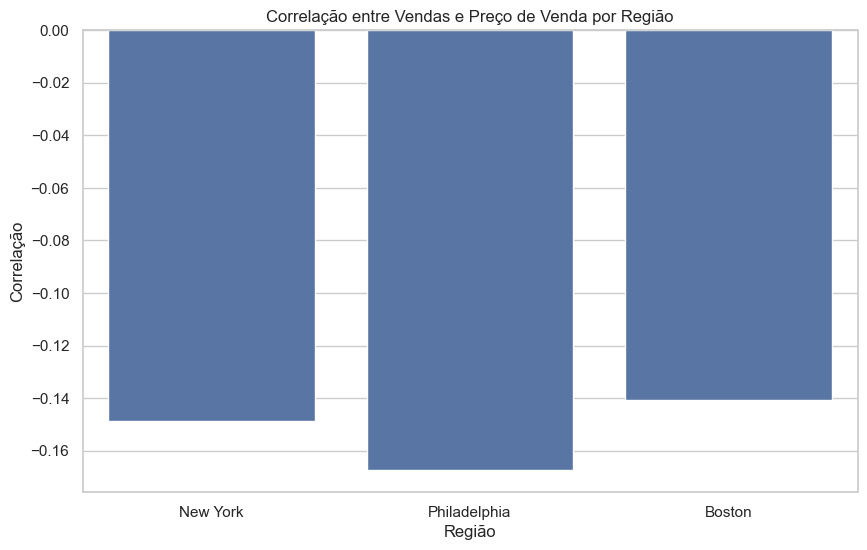

In [32]:
# Exemplo de visualização: Correlação entre Vendas e Preço de Venda por Região
plt.figure(figsize=(10, 6))
sns.barplot(data=df_correlacao_vendas_preco, x='region', y='sales_sell_price_corr')
plt.title('Correlação entre Vendas e Preço de Venda por Região')
plt.xlabel('Região')
plt.ylabel('Correlação')
plt.show()

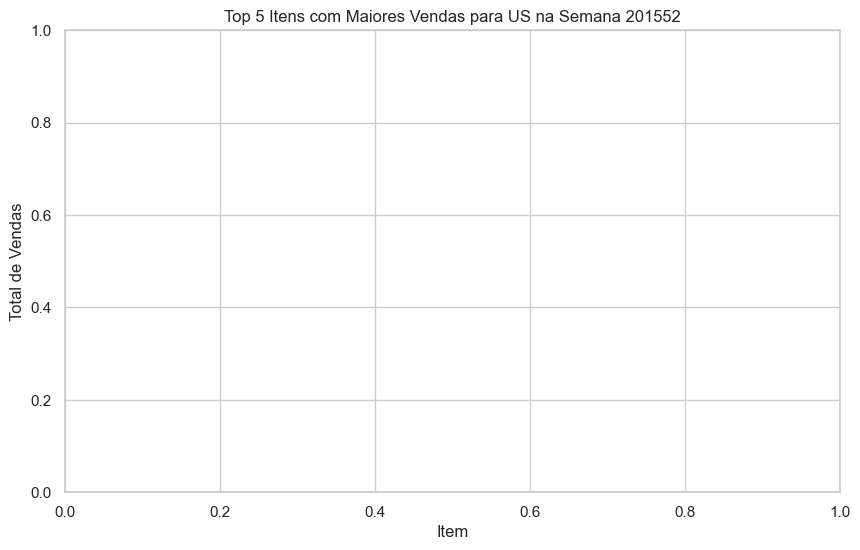

In [33]:
# Exemplo de visualização: Top 5 Itens com Maiores Vendas para US na Semana 201552
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_5_itens, x='item', y='total_sales')
plt.title('Top 5 Itens com Maiores Vendas para US na Semana 201552')
plt.xlabel('Item')
plt.ylabel('Total de Vendas')
plt.show()

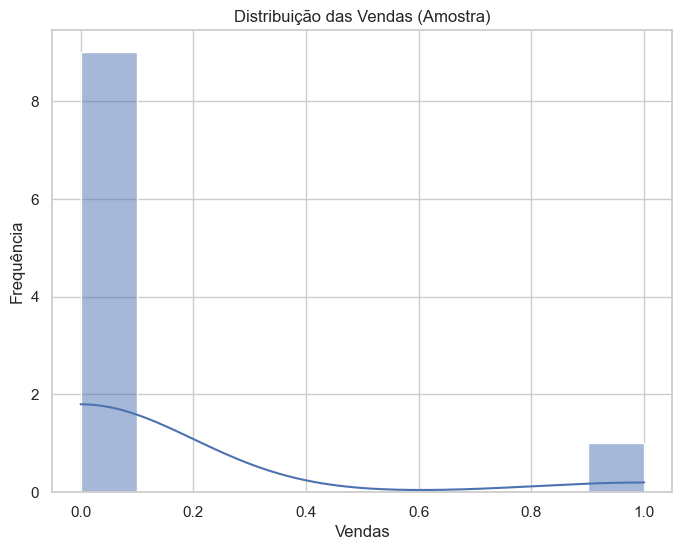

In [34]:
# Distribuição das Vendas
plt.figure(figsize=(8,6))
sns.histplot(df_sample['sales'], bins=10, kde=True)
plt.title('Distribuição das Vendas (Amostra)')
plt.xlabel('Vendas')
plt.ylabel('Frequência')
plt.show()

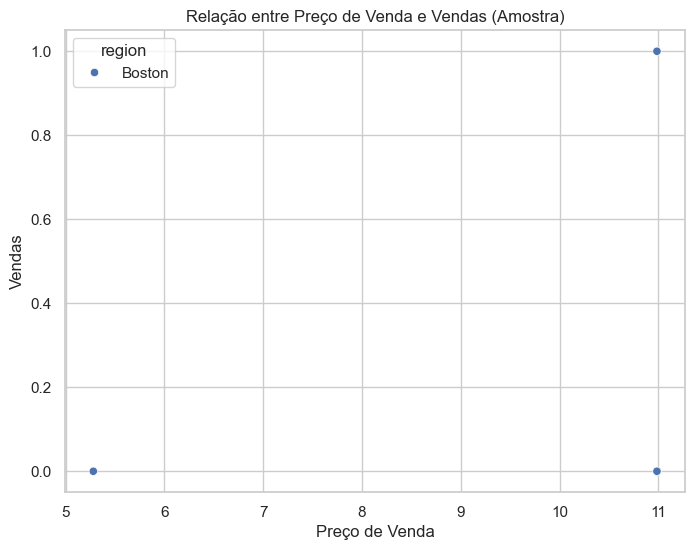

In [35]:
# Relação entre Preço de Venda e Vendas
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sample, x='sell_price', y='sales', hue='region')
plt.title('Relação entre Preço de Venda e Vendas (Amostra)')
plt.xlabel('Preço de Venda')
plt.ylabel('Vendas')
plt.show()

## 7. Modelos de Machine Learning

### 7.1. BigQuery ML - Previsão de Vendas Futuras

#### 7.1.1. Criando e Treinando um Modelo de Classificação Logística com BigQuery ML

In [39]:
# Definir a consulta para criar o modelo de classificação logística
create_model_query = """
CREATE OR REPLACE MODEL `TFM.sales_predict_model`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['sales']
) AS
WITH top_labels AS (
  SELECT
    sales,
    COUNT(*) AS count
  FROM
    `TFM.ds_market`
  GROUP BY
    sales
  ORDER BY
    count DESC
  LIMIT 50
)
SELECT
  sell_price,
  category_x,
  department,
  region,
  event,
  yearweek,
  d,
  store_code,
  sales
FROM
  `TFM.ds_market`
WHERE
  date BETWEEN '2011-01-01' AND '2016-12-31'
  AND sales IN (SELECT sales FROM top_labels);
"""

# Executar a consulta para criar o modelo
client.query(create_model_query).result()
print("Modelo de Classificação Logística criado com sucesso.")

Modelo de Classificação Logística criado com sucesso.


In [50]:
# Definir a consulta para fazer previsões
predict_query = """
SELECT
  sell_price,
  category_x,
  department,
  region,
  event,
  yearweek,
  d,
  store_code,
  predicted_sales
FROM
  ML.PREDICT(MODEL `TFM.sales_predict_model`,
    (
      SELECT
        sell_price,
        category_x,
        department,
        region,
        event,
        yearweek,
        d,
        store_code
      FROM
        `TFM.ds_market`
      WHERE
        date BETWEEN '2016-01-01' AND '2016-12-31'
    )
  );
"""

# Executar a consulta de previsão
df_predictions = executar_consulta(predict_query, client)
print("Previsões realizadas com sucesso.")
df_predictions.head()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



Previsões realizadas com sucesso.


,sell_price,category_x,department,region,event,yearweek,d,store_code,predicted_sales
0,NaN,SUPERMARKET,SUPERMARKET_3,New York,NewYear,201553,d_1799,NYC_3,0
1,NaN,SUPERMARKET,SUPERMARKET_3,New York,NewYear,201553,d_1799,NYC_2,0
2,NaN,HOME_&_GARDEN,HOME_&_GARDEN_1,Boston,NewYear,201553,d_1799,BOS_3,0
3,NaN,SUPERMARKET,SUPERMARKET_1,Philadelphia,NewYear,201553,d_1799,PHI_1,0
4,NaN,HOME_&_GARDEN,HOME_&_GARDEN_1,Philadelphia,NewYear,201553,d_1799,PHI_2,0
